In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
batch_size = 4
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_indices = list(range(len(data)))[:40000]
validation_indices = list(range(len(data)))[40000:]

# train_sample = torch.utils.data.SubsetRandomSampler(train_indices)
# validation_sample = torch.utils.data.SubsetRandomSampler(validation_indices)


# Subsets of the whole train data using the sampled indices
trainset = torch.utils.data.Subset(data, train_indices)
validationset = torch.utils.data.Subset(data, train_indices)

# Dataloader using the created subsets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print('Train set size: ', len(trainloader) * 4)
print('Validation set size: ', len(validationloader) * 4)
print('Test set size: ', len(testloader) * 4)

Train set size:  40000
Validation set size:  40000
Test set size:  10000


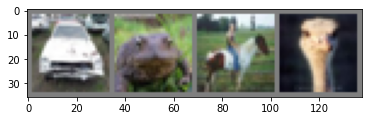

  car  frog horse  bird


In [4]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

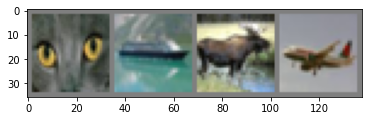

  cat  ship  deer plane


In [5]:
# Get some random valldation images.
dataiter = iter(validationloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [6]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [7]:
class NetMod(nn.Module):
    def __init__(self):
        super(NetMod, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(in_features=256, out_features=10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(F.relu(x))
        x = self.dropout2(x)
        x = self.fc3(F.relu(x))
        x = F.relu(x)
        return x

net = NetMod()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

NetMod(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [8]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=2, threshold=0.01, verbose=True)

In [9]:
avg_losses = []   # Avg. losses.
validation_losses = []
epochs = 90       # Total epochs.
print_freq = 2000  # Print frequency.
lr_list = set()

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    validation_loss = 0.0
    
    net.train()
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq    
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

    net.eval()
    with torch.no_grad():
        for i, data in enumerate(validationloader, 0):
            # Get the inputs.
            inputs, labels = data

            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward step.
            outputs = net(inputs)
            loss = loss_func(outputs, labels)
            validation_loss += loss.item()
            validation_losses.append(validation_loss)
    net.train()
    
    # If validation error no longer improve, divide the lr by 10
    scheduler.step(validation_loss)
    print('Validation Loss: ', validation_loss)
    lr_list.add(scheduler._last_lr[0])
                            

print('Finished Training.')
print('LR list: ', lr_list)

[epoch: 0, i:  1999] avg mini-batch loss: 2.2452539670467377
[epoch: 0, i:  3999] avg mini-batch loss: 2.173247222572565
[epoch: 0, i:  5999] avg mini-batch loss: 2.1244121899604798
[epoch: 0, i:  7999] avg mini-batch loss: 2.0852758308649064
[epoch: 0, i:  9999] avg mini-batch loss: 2.0194630535542966
Validation Loss:  19499.51106452942
[epoch: 1, i:  1999] avg mini-batch loss: 1.9596579679250716
[epoch: 1, i:  3999] avg mini-batch loss: 1.914217490196228
[epoch: 1, i:  5999] avg mini-batch loss: 1.8705782504677773
[epoch: 1, i:  7999] avg mini-batch loss: 1.8589486284554004
[epoch: 1, i:  9999] avg mini-batch loss: 1.8172940184399486
Validation Loss:  17660.897290319204
[epoch: 2, i:  1999] avg mini-batch loss: 1.7541345311328769
[epoch: 2, i:  3999] avg mini-batch loss: 1.7659297703951597
[epoch: 2, i:  5999] avg mini-batch loss: 1.7320872030854224
[epoch: 2, i:  7999] avg mini-batch loss: 1.713804952705279
[epoch: 2, i:  9999] avg mini-batch loss: 1.6645768001843244
Validation Loss

Validation Loss:  953.5549471768322
[epoch: 24, i:  1999] avg mini-batch loss: 0.10643109960058712
[epoch: 24, i:  3999] avg mini-batch loss: 0.10710953782925567
[epoch: 24, i:  5999] avg mini-batch loss: 0.12674794556209873
[epoch: 24, i:  7999] avg mini-batch loss: 0.11869125851930508
[epoch: 24, i:  9999] avg mini-batch loss: 0.14052907527455386
Validation Loss:  644.7358398892401
[epoch: 25, i:  1999] avg mini-batch loss: 0.09094775292888262
[epoch: 25, i:  3999] avg mini-batch loss: 0.11916409466100243
[epoch: 25, i:  5999] avg mini-batch loss: 0.10791177722249927
[epoch: 25, i:  7999] avg mini-batch loss: 0.11507655868514166
[epoch: 25, i:  9999] avg mini-batch loss: 0.11953226380526846
Validation Loss:  601.859008174798
[epoch: 26, i:  1999] avg mini-batch loss: 0.10073260746821135
[epoch: 26, i:  3999] avg mini-batch loss: 0.10676345252452925
[epoch: 26, i:  5999] avg mini-batch loss: 0.10189957534837027
[epoch: 26, i:  7999] avg mini-batch loss: 0.11702931255776057
[epoch: 26,

Validation Loss:  23.611551661931472
[epoch: 47, i:  1999] avg mini-batch loss: 0.0053051114885788305
[epoch: 47, i:  3999] avg mini-batch loss: 0.0061144791137201365
[epoch: 47, i:  5999] avg mini-batch loss: 0.006326135869260781
[epoch: 47, i:  7999] avg mini-batch loss: 0.005363898136007407
[epoch: 47, i:  9999] avg mini-batch loss: 0.00700443437142107
Epoch 00048: reducing learning rate of group 0 to 1.0000e-06.
Validation Loss:  18.751522885830266
[epoch: 48, i:  1999] avg mini-batch loss: 0.00589362133508504
[epoch: 48, i:  3999] avg mini-batch loss: 0.004306101427262039
[epoch: 48, i:  5999] avg mini-batch loss: 0.004445725842880164
[epoch: 48, i:  7999] avg mini-batch loss: 0.004777930928430397
[epoch: 48, i:  9999] avg mini-batch loss: 0.004110174231615087
Validation Loss:  12.033494241063233
[epoch: 49, i:  1999] avg mini-batch loss: 0.004276165231776119
[epoch: 49, i:  3999] avg mini-batch loss: 0.0037994165458208684
[epoch: 49, i:  5999] avg mini-batch loss: 0.0038674493349

[epoch: 69, i:  5999] avg mini-batch loss: 0.003827280784743792
[epoch: 69, i:  7999] avg mini-batch loss: 0.0039058562449770734
[epoch: 69, i:  9999] avg mini-batch loss: 0.004119204703661417
Validation Loss:  9.995572400435464
[epoch: 70, i:  1999] avg mini-batch loss: 0.004983976578769058
[epoch: 70, i:  3999] avg mini-batch loss: 0.0036923722688861674
[epoch: 70, i:  5999] avg mini-batch loss: 0.003485186667845895
[epoch: 70, i:  7999] avg mini-batch loss: 0.004195271077711794
[epoch: 70, i:  9999] avg mini-batch loss: 0.004100224704375549
Validation Loss:  9.98772970027225
[epoch: 71, i:  1999] avg mini-batch loss: 0.0035663202794183916
[epoch: 71, i:  3999] avg mini-batch loss: 0.0037760477911121483
[epoch: 71, i:  5999] avg mini-batch loss: 0.004248039078175466
[epoch: 71, i:  7999] avg mini-batch loss: 0.0045851982375479695
[epoch: 71, i:  9999] avg mini-batch loss: 0.004059236469669564
Validation Loss:  9.980365043512341
[epoch: 72, i:  1999] avg mini-batch loss: 0.00432351618

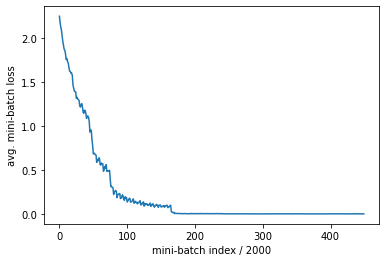

In [10]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

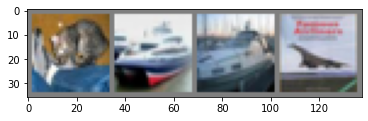

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [11]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

In [12]:
# Get test accuracy.
correct = 0
total = 0

net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

net.train()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 79 %


In [13]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 83 %
Accuracy of   car : 88 %
Accuracy of  bird : 69 %
Accuracy of   cat : 59 %
Accuracy of  deer : 73 %
Accuracy of   dog : 69 %
Accuracy of  frog : 86 %
Accuracy of horse : 81 %
Accuracy of  ship : 88 %
Accuracy of truck : 87 %
